## WHOLE IMAGE TESTING AND mIOU Calculation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

from torchvision import transforms, utils, models
import torchvision.transforms.functional as TF

import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import os
import imageio

from PIL import Image

import skimage.external.tifffile as tifffile
import cv2
import glob

import os,sys,inspect
ConvCRF_dir = '../ConvCRF'
sys.path.insert(0,ConvCRF_dir)
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
from backboned_unet import Unet
# 'resnet'- 18, 34, 50, 101, 152
# 'vgg'- 16, 19
# 'densenet' - 121, 161, 169, 201

model1 = Unet(backbone_name='resnet34', classes=2)

upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [4]:
model1

Unet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [7]:
"PLEASE SET THESE VALUES"

patch_size = 480
overlap = 1/2 # Greater the denominator, Greater the overlap
black_patches = False # Include black patches?
floe_only = True # Include only patches that contain a floe?

In [8]:
if(patch_size * overlap).is_integer():
    print(f"Overlap of {overlap} is accepted")
    step = int(patch_size * overlap)

else:
    print(f"Overlap of {overlap} is NOT ACCEPTED, Please input something else like 1/2, 1/4, 1/6, 1/8, 1/12")

Overlap of 0.5 is accepted


In [9]:
"""
TEST IMAGES
im_rsat2_ar_20110615105638_00079057_l
im_rsat2_ar_20140615112940_00115653_l

VAL IMAGES
im_rsat2_ar_20120508112949_00091906_l
im_rsat2_ar_20120606104418_00092688_l
"""

'\nTEST IMAGES\nim_rsat2_ar_20110615105638_00079057_l\nim_rsat2_ar_20140615112940_00115653_l\n\nVAL IMAGES\nim_rsat2_ar_20120508112949_00091906_l\nim_rsat2_ar_20120606104418_00092688_l\n'

In [12]:
img_name = 'im_rsat2_ar_20110615105638_00079057_l.tif'
mode = 'test'

image = tifffile.imread('/home/muzik999/MASc/iceFloe/floes/data/images/'+mode+'/' + img_name)
mask = plt.imread('/home/muzik999/MASc/iceFloe/floes/data/annotation_masks/' + img_name[:-4] + '.png')[:,:,0]
mask = np.ceil(mask).astype(np.uint8)

img_save_dir = '/home/muzik999/MASc/iceFloe/floes/data/'+mode+'/whole_images/192/img/'
mask_save_dir = '/home/muzik999/MASc/iceFloe/floes/data/'+mode+'/whole_images/192/mask/'

In [13]:
img_x, img_y = image.shape

In [14]:
left = 0
top = 0
right = patch_size - (img_y % patch_size)
bottom = patch_size - (img_x % patch_size)

In [15]:
image_padded = TF.pad(TF.to_pil_image(image), (left, top, right, bottom))
_, img_go_x, img_go_y = TF.to_tensor(image_padded).shape

mask_padded = TF.pad(TF.to_pil_image(mask), (left, top, right, bottom))

In [19]:
# from torchvision.models.segmentation.deeplabv3 import DeepLabHead
# model1 = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model1.classifier = DeepLabHead(2048, 1)

In [10]:
# resnet = models.resnet34(pretrained=True)
# layers = list(resnet.children())
# from model.architecture import ResUNet

In [11]:
# """FCN RESNET101"""

# from torchvision.models.segmentation.fcn import FCNHead
# model = models.segmentation.fcn_resnet101(pretrained=True)
# model.classifier = FCNHead(2048, 1)

In [12]:
# from model.architecture import UNet
# model1 = UNet(1)

In [16]:
model1 = torch.load('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/NEW_RESUNET_model1RESUNET_2000iter_NEW_DATA_FT.mdl')
# model1 = torch.load('../model/weights/UNET_CRF/NEW/8_192_model1DLv3_1500iter_NEW_DATA.mdl')

In [17]:
from tools.crf_conf import default_conf as conf
from convcrf import convcrf

conf['filter_size'] = 1
conf['blur'] = 0
conf['trainable'] = False
conf['trainable_bias'] = False

In [18]:
model2 = convcrf.GaussCRF(conf=conf, shape=(patch_size,patch_size), nclasses=2)
model2 = torch.load('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/NEW_RESUNET_model21RESUNET_2000iter_NEW_DATA_FT.mdl')
model2.cuda()

GaussCRF(
  (CRF): ConvCRF()
)

In [19]:
model1.cuda()
model1.eval()
with torch.no_grad():
    pred1_list = []
    pred2_list = []
    mask_list = []
    
    image_mask = torch.zeros((img_go_x+step, img_go_y+step))

    for i in range(0,img_go_x, step):
        for j in range(0,img_go_y, step):

            patch_img = TF.crop(image_padded, i,j,patch_size,patch_size)
            patch_img_tensor = TF.to_tensor(patch_img) * 255
            img_patch_save = np.array(torch.stack((patch_img_tensor.squeeze(), patch_img_tensor.squeeze(), patch_img_tensor.squeeze()), dim = 0)).astype(np.uint8)

            patch_mask = TF.crop(mask_padded, i,j,patch_size,patch_size)
            patch_mask_tensor = TF.to_tensor(patch_mask) * 255
            mask_patch_save = np.array(patch_mask_tensor.squeeze())
            
            img_tensor = torch.tensor(img_patch_save).unsqueeze(0)
            img_tensor = img_tensor.to('cuda', dtype=torch.float)
            
            pred1 = model1(img_tensor)
            pred2 = model2(unary = pred1, img = img_tensor)
            pred1_list.append(pred1.cpu().detach())
            
            mask_list.append(mask)
            
            image_mask[i: i+patch_size, j: j+patch_size] += (torch.sigmoid(pred2[0,1,:,:].squeeze())>0.5).cpu().detach() # [0,1,:,:] for RESUNET and ['out'][0,0,:,:] for DLV3 and [0,0,:,:] for normal UNET

In [20]:
from sklearn.metrics import confusion_matrix
def compute_miou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    
    return np.mean(IoU)

In [21]:
x,y = mask.shape

In [14]:
#RESUNET+CRF
# compute_miou(y_pred = (image_mask[:x, :y]>0.1), y_true = mask)  # im_rsat2_ar_20130614223435_00105110_l 0.79284

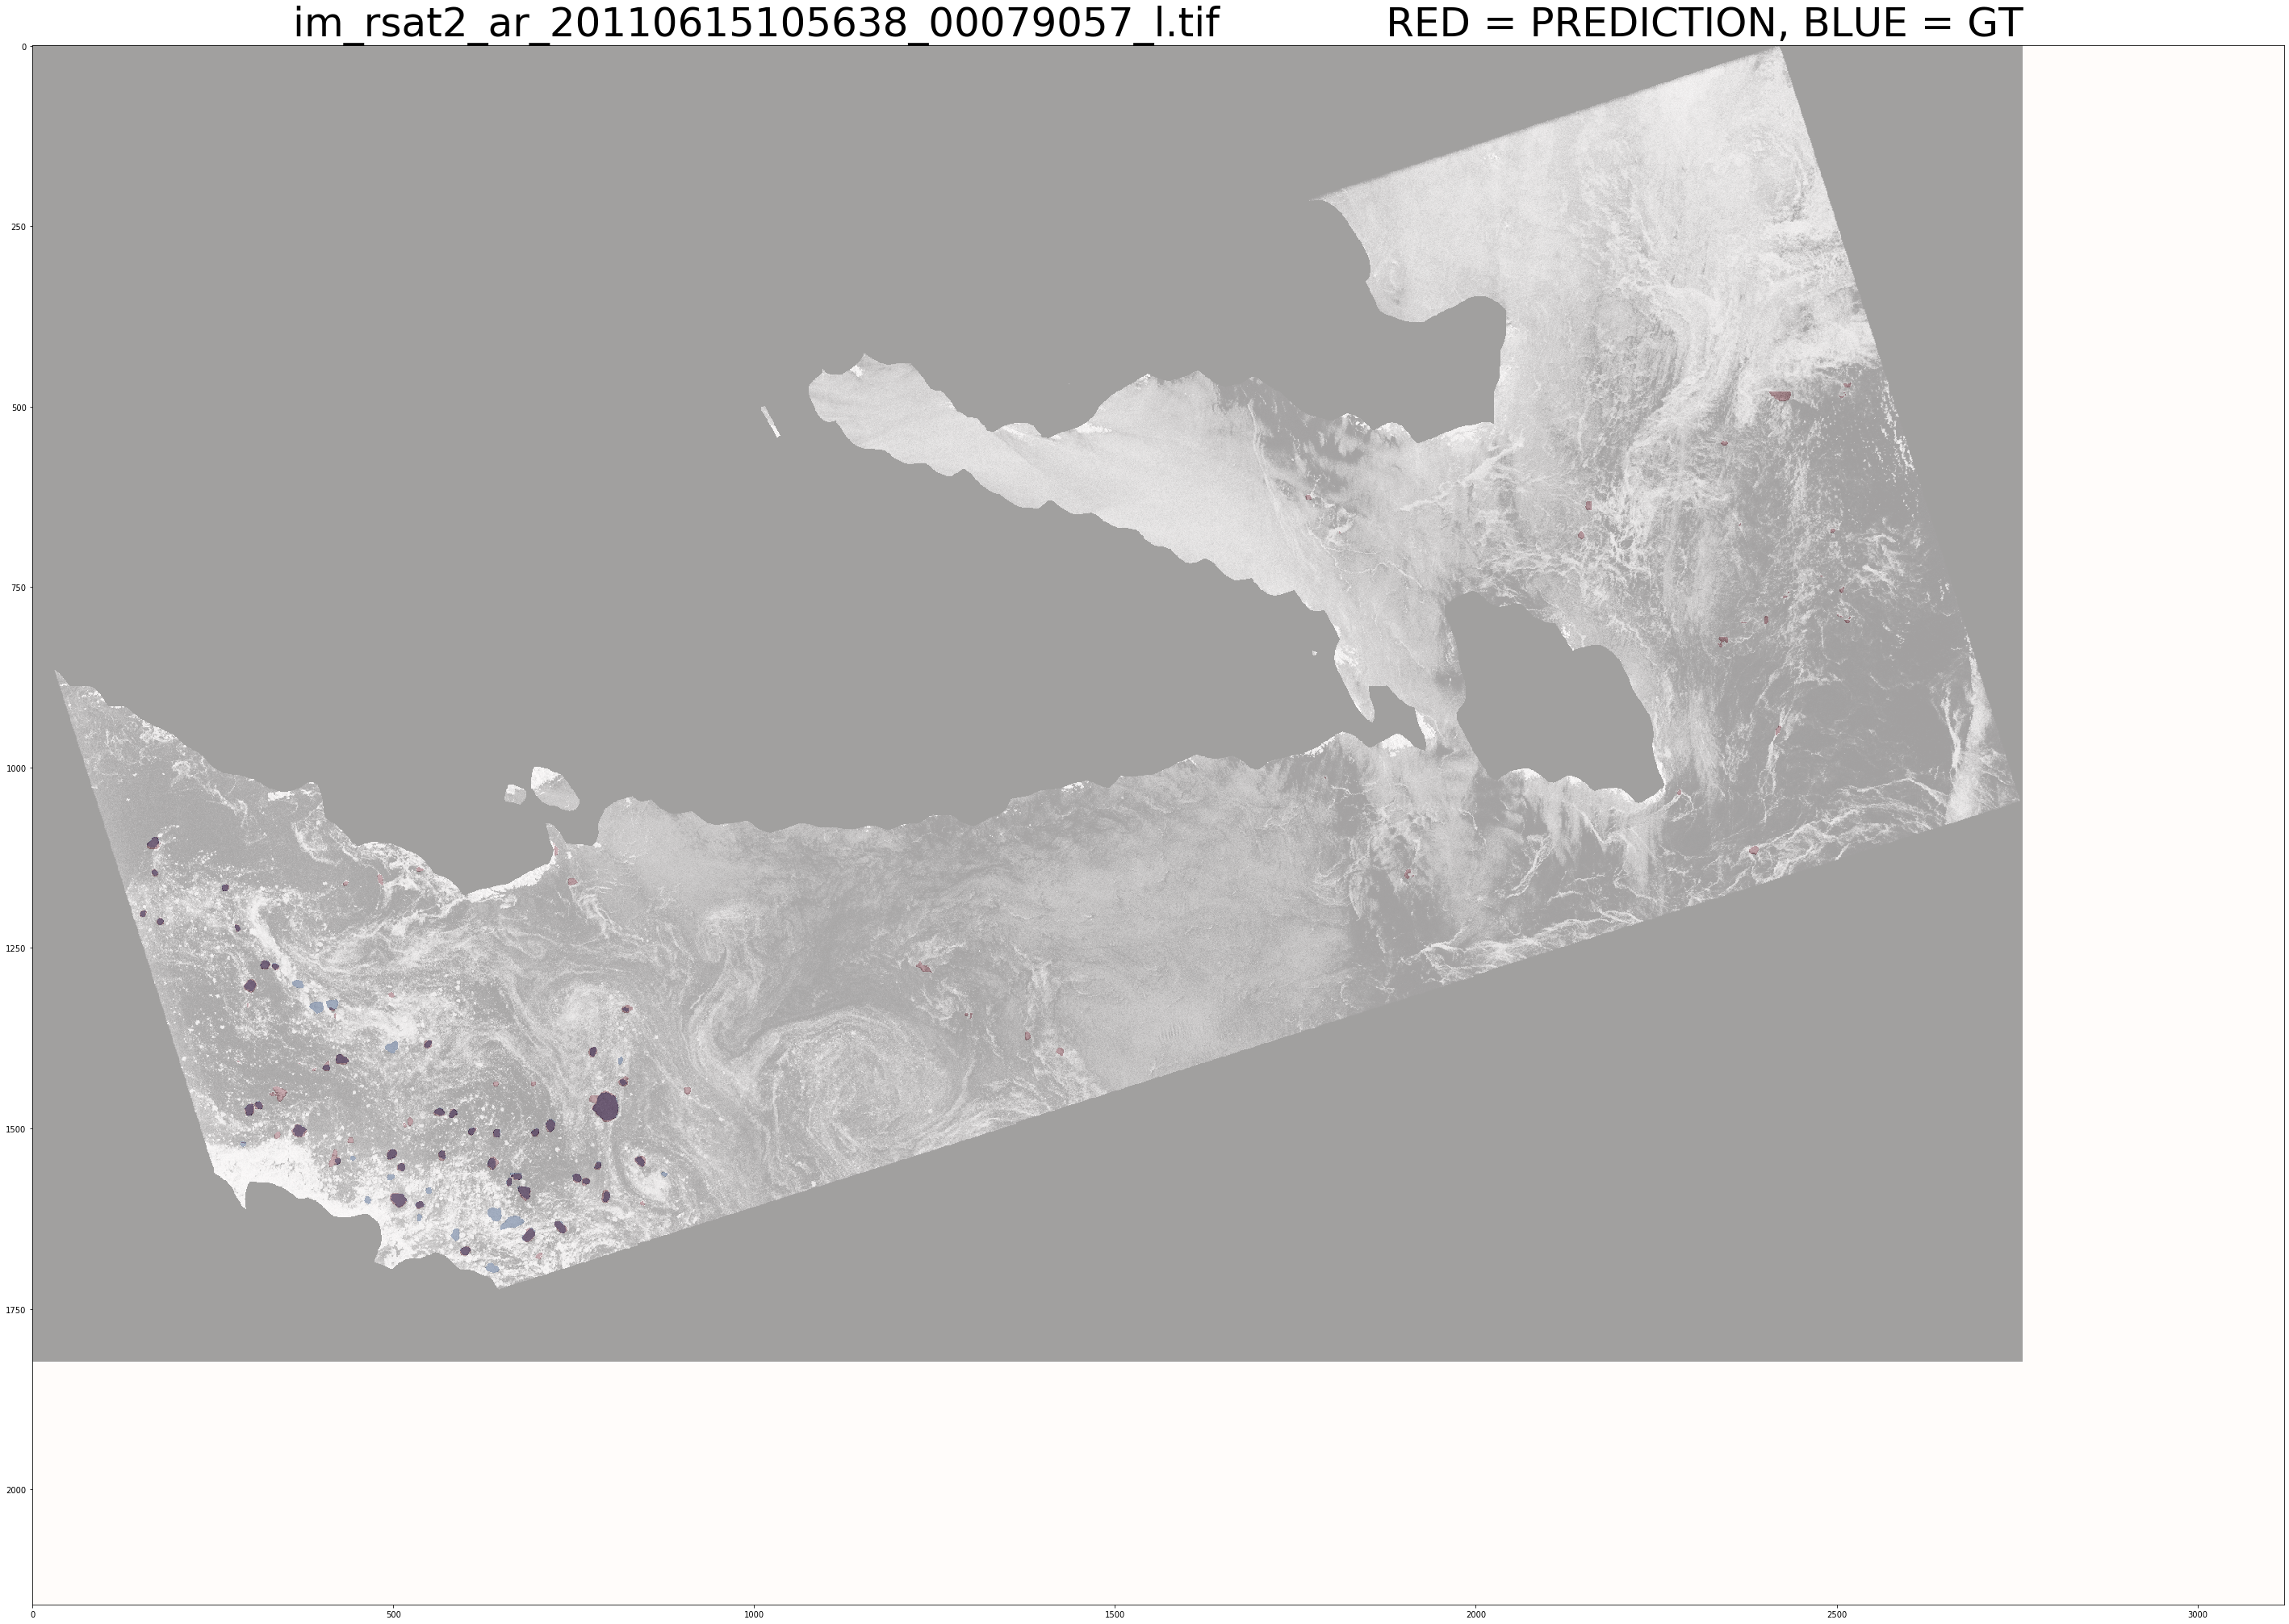

In [13]:
plt.figure(figsize=(50,50))
plt.title(img_name + '             RED = PREDICTION, BLUE = GT', fontdict={'fontsize': 50})
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.5)
plt.imshow((image_mask>0.9), cmap='Reds', alpha=0.3)

# plt.savefig('../results/1_UNET_480)' + img_name[:-4] + '.png')

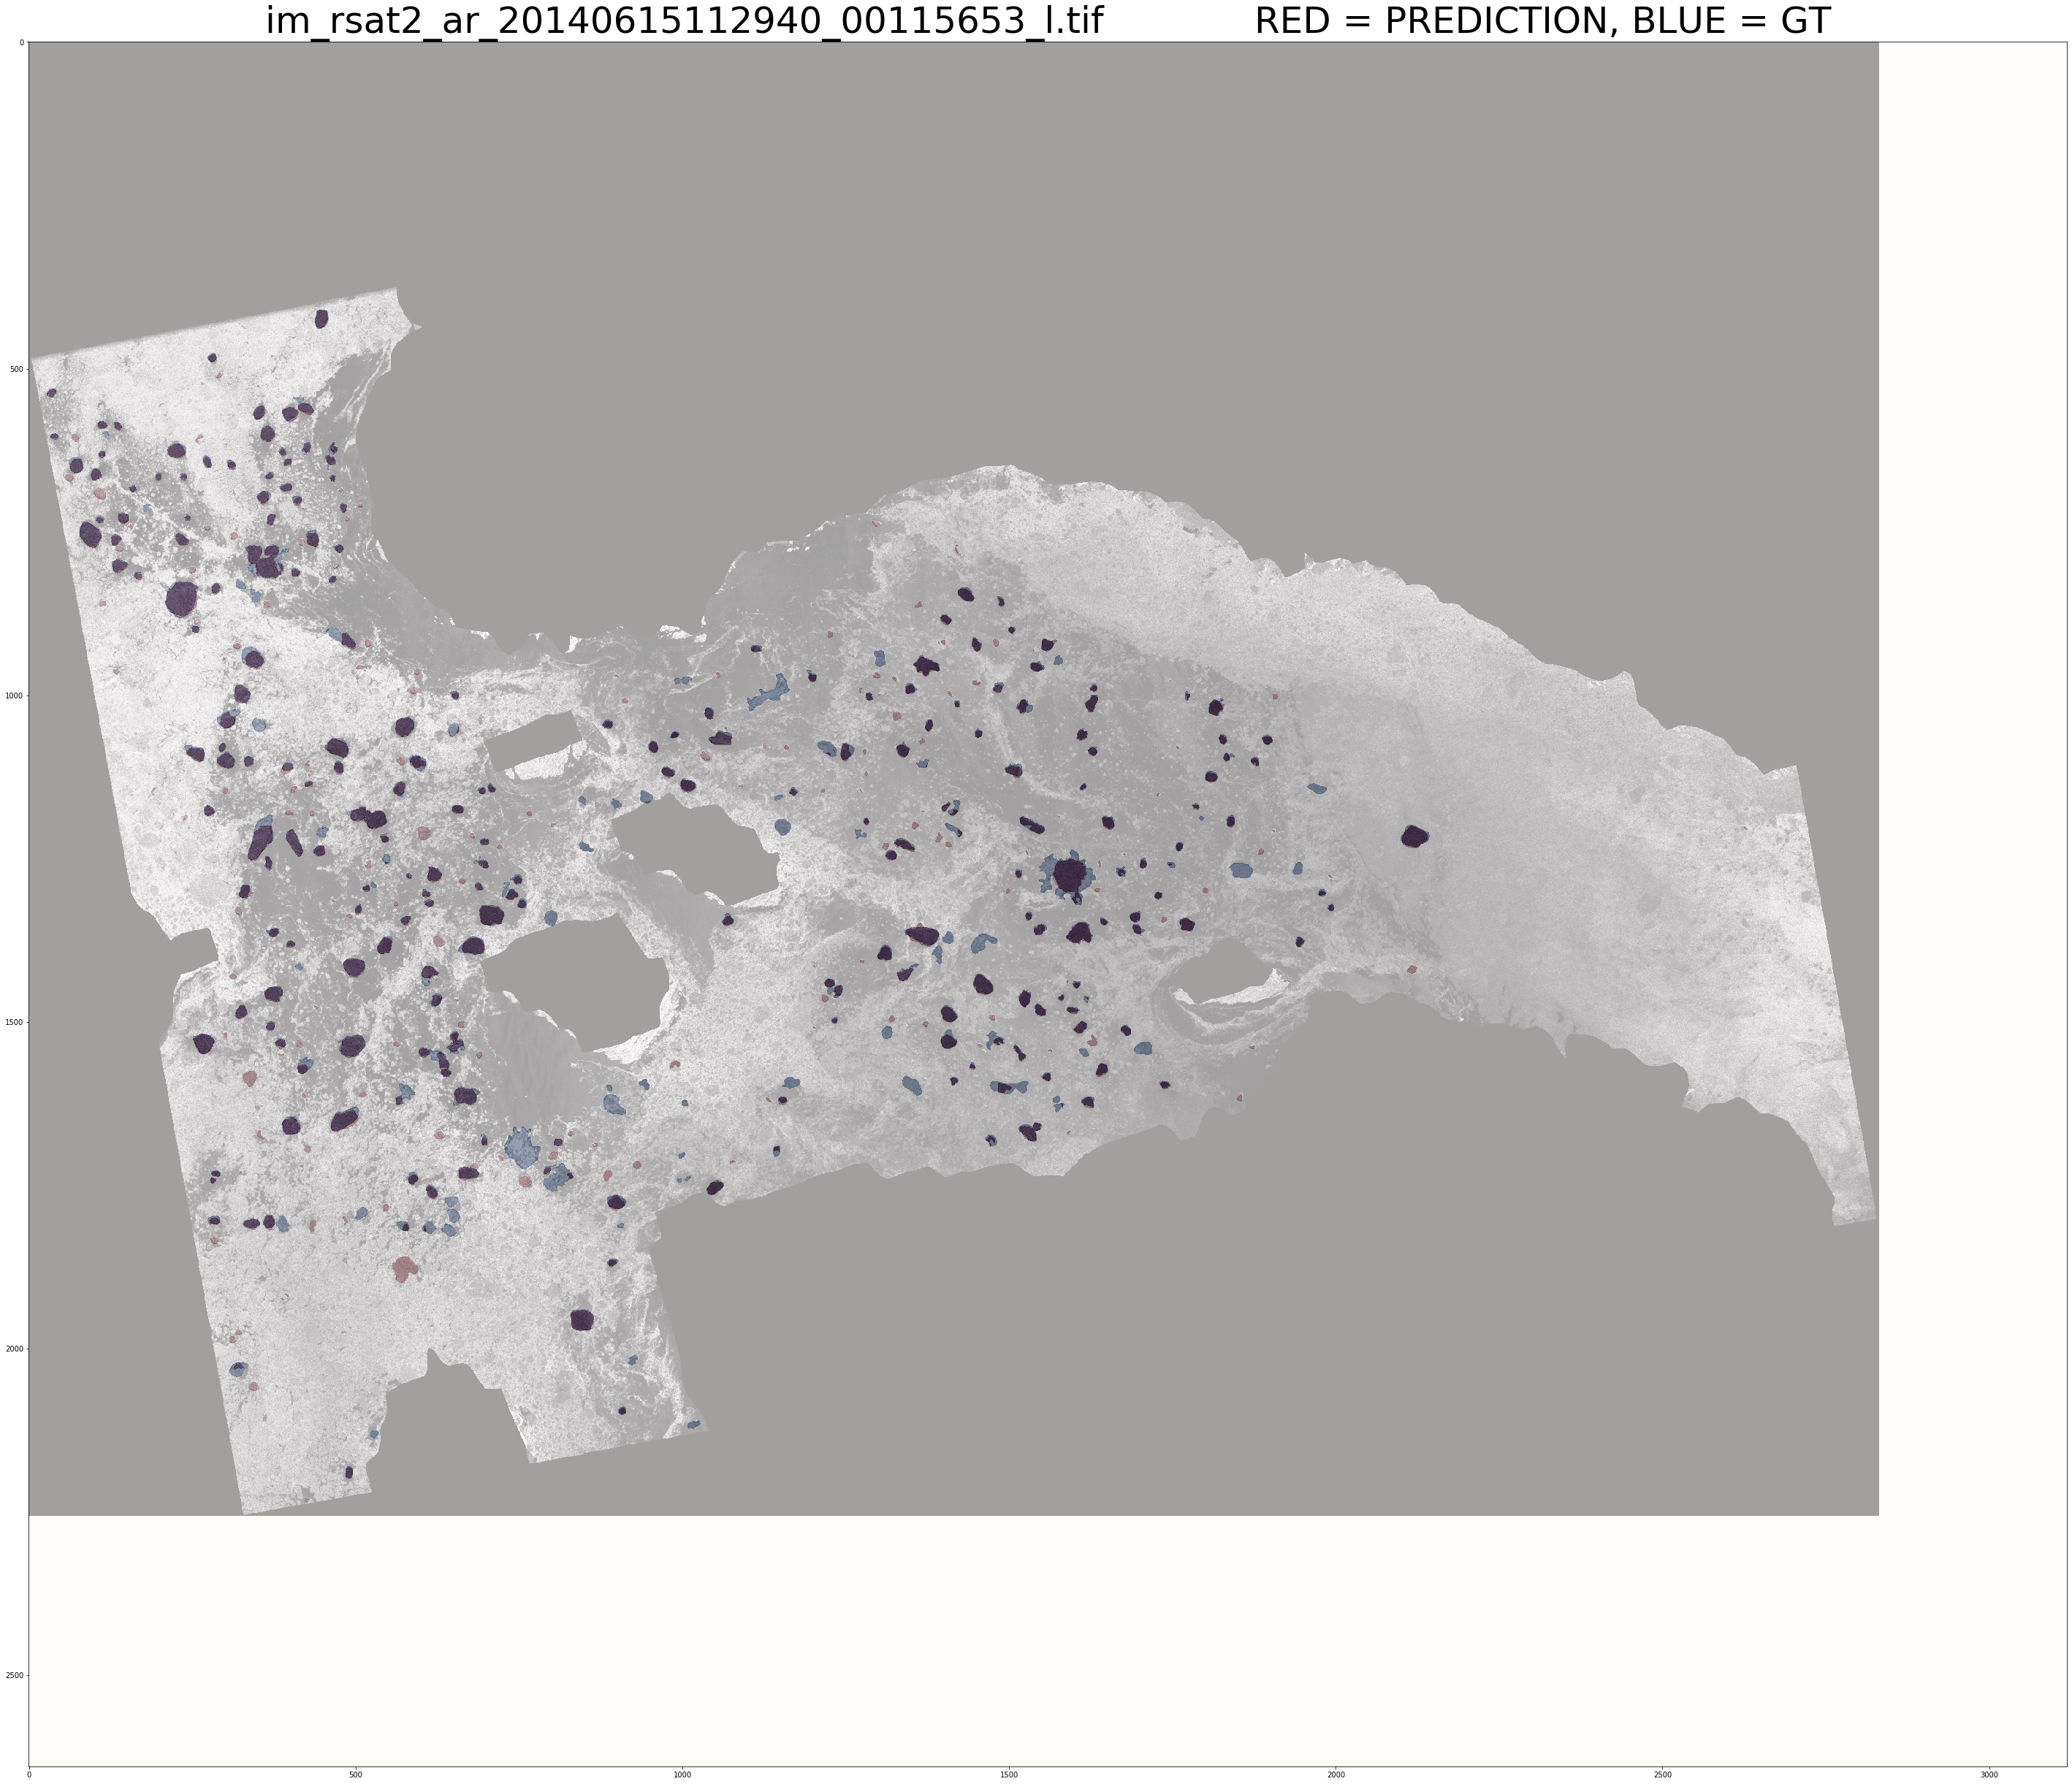

In [23]:
plt.figure(figsize=(50,50))
plt.title(img_name + '             RED = PREDICTION, BLUE = GT', fontdict={'fontsize': 50})
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.5)
plt.imshow((image_mask>0.9), cmap='Reds', alpha=0.3)

# plt.savefig('../results/1_UNET_480)' + img_name[:-4] + '.png')

In [32]:
# plt.figure(figsize=(50,50))
# plt.title(img_name + '             BLUE = GT', fontdict={'fontsize': 50})
# plt.imshow(image, cmap='gray')
# plt.imshow(mask, cmap='Blues', alpha=0.45)

# # plt.savefig('../results/GT_' + img_name[:-4] + '.png')

In [14]:
image_mask_96_1 = image_mask[:x, :y]
mask_96_1 = mask

In [24]:
image_mask_96_2 = image_mask[:x, :y]
mask_96_2 = mask

In [25]:
pred = torch.cat(((image_mask_96_1>0.1).flatten(),(image_mask_96_2>0.1).flatten())).flatten()

In [26]:
mskk = np.concatenate((mask_96_1.flatten(),mask_96_2.flatten())).flatten()

In [27]:
pred.shape == mskk.shape

True

In [28]:
compute_miou(y_pred = image_mask_96_1>0.1, y_true = mask_96_1) 

0.7274713221631567

In [29]:
compute_miou(y_pred = image_mask_96_2>0.1, y_true = mask_96_2) 

0.7787392144724663

In [30]:
compute_miou(y_pred = pred, y_true = mskk) 

0.7743277374700299

In [ ]:
# 0.9 and 1 work good for img 1
# 0.7 and 1 work good for img 2